In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import time
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 불러오기
데이터 출처 - https://cseweb.ucsd.edu/~jmcauley/datasets.html#multi_aspect

1. 행간이 "\n" 으로 구분된 ".json" file 업로드 (```pd.read_json```)
2. 결측치 1개 제거 (마지막행이 업로드시 이슈가 발생하는 것 같다) (```pd.DataFrame.dropna()```)

In [3]:
ratebeer = pd.read_json("../data/new_ratebeer.json", lines=True).dropna()

# 데이터 탐색

## 변수 설명
참고자료 - https://www.ratebeer.com/Story.asp?StoryID=292

- `beer/name`: 맥주 이름(상표)
- `beer/beerId`: 맥주 일련번호(코드)
- `beer/brewerId`: 맥주 생산자 일련번호
- `beer/ABV`: 맥주 알코올 도수(Alcohol by volume, %)
- `beer/style`: 맥주 카테고리
- `review/appearance`: 평가점수-외관(look) 
- `review/aroma`: 평가점수-향기(smell)
- `review/palate`: 평가점수-the sense of taste(feel)
- `review/taste`: 평가점수-맛
- `review/overall`: 평가점수-종합
- `review/time`: 평가 시간
- `review/profileName`: 유저ID
- `review/text`: 리뷰 코멘트
  
  



In [4]:
ratebeer.head(3)

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,1.157587e+09,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,1.157242e+09,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481.0,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,9.586944e+08,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."


In [5]:
n_data, n_var = ratebeer.shape
print('[ratebeer] 데이터 길이 : ',format(n_data, ','))
print('[ratebeer] 변수 개수  : ', format(n_var, ','))

[ratebeer] 데이터 길이 :  2,924,163
[ratebeer] 변수 개수  :  13


In [6]:
# 표면상 데이터 결측치 확인
ratebeer.isna().sum()

beer/name             0
beer/beerId           0
beer/brewerId         0
beer/ABV              0
beer/style            0
review/appearance     0
review/aroma          0
review/palate         0
review/taste          0
review/overall        0
review/time           0
review/profileName    0
review/text           0
dtype: int64

### beer/name - 맥주 이름 (상표) 탐색

In [7]:
# beer/name 맥주 이름 (상표) 탐색
n_item = ratebeer['beer/name'].nunique()
print(f"[ratebeer] 맥주의 종류: {n_item:,}가지")
# print(f"[ratebeer] 맥주의 스타일 종류: {ratebeer['beer/style'].nunique():,}")

# beer/beerId 와의 관계
n_itemId = ratebeer['beer/beerId'].nunique() # 개념상 개수가 같아야하는데, `beer/beerId`가 조금 더 많다. Why?
print(f"[ratebeer] 맥주의 일련번호: {n_itemId:,}가지")


[ratebeer] 맥주의 종류: 110,299가지
[ratebeer] 맥주의 일련번호: 110,369가지


In [8]:
# 포함관계 확인;  (가정) beer/name 개수가 더 적기 때문에, 더 상위의 개념일 것이다. 
rel_beer = ratebeer.groupby(["beer/name", "beer/beerId"]).count().reset_index([0, 1])[["beer/name", "beer/beerId", "beer/brewerId"]]
rel_beer.columns = ["beer/name", "beer/beerId", "counts"]

# 1 대 1 관계에 있는 맥주이름-맥주ID 개수
item_1to1 = sum(rel_beer.groupby("beer/name")['beer/beerId'].count() == 1)
print(f">>> 1 대 1 관계에 있는 맥주이름-맥주ID 개수: {item_1to1:7,}")

# 1 대 N 관계에 있는 맥주이름-맥주ID 개수
item_1toN = sum(rel_beer.groupby("beer/name")['beer/beerId'].count() != 1)
print(f">>> 1 대 N 관계에 있는 맥주이름-맥주ID 개수: {item_1toN:7,}")

print()
table_1toN = rel_beer.groupby("beer/name")['beer/beerId'].count()[rel_beer.groupby("beer/name")['beer/beerId'].count() != 1].value_counts()#.reset_index()
print("하나의 맥주 이름(beer/name)에 ")
for i, value in table_1toN.iteritems():
    print(f"- {i} 개의 중복된 맥주 일련번호가 존재하는 맥주는 {value:2} 개 이다.")

>>> 1 대 1 관계에 있는 맥주이름-맥주ID 개수: 110,231
>>> 1 대 N 관계에 있는 맥주이름-맥주ID 개수:      68

하나의 맥주 이름(beer/name)에 
- 2 개의 중복된 맥주 일련번호가 존재하는 맥주는 66 개 이다.
- 3 개의 중복된 맥주 일련번호가 존재하는 맥주는  2 개 이다.


In [9]:
# 68개에 해당하는 맥주에 대해서 탐사해볼필요가 있다.

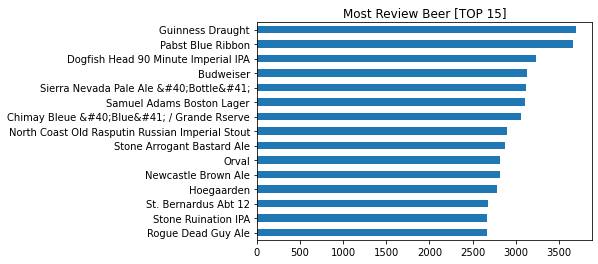

In [10]:
# 어떤 맥주가 리뷰 횟수가 많을까? 상위 15개의 맥주만 한 번 뽑아보자.
ratebeer['beer/name'].value_counts()[:15][::-1].plot(kind = 'barh')
plt.title("Most Review Beer [TOP 15]")
plt.show()

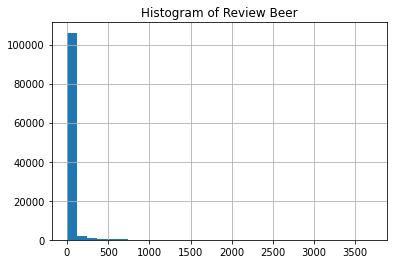

In [11]:
# 맥주 리뷰 횟수의 분포를 확인해보자
ratebeer['beer/name'].value_counts().hist(bins=30)
plt.title("Histogram of Review Beer")
plt.show()

In [12]:
# 거의 대부분의 맥주가 리뷰 횟수가 적다. -> 대부분의 맥주는 잘 조회되지 않는다. 

In [13]:
# 그렇다면, 리뷰 개수가 적은 맥주는 몇 개나 있을까? 

print(f"* 해당 데이터 안에서 존재하는 맥주의 총 가지 수  = {n_item:,}", end="\n\n")
for index, value in ratebeer['beer/name'].value_counts().value_counts().items():
    # print(index, value)
    print(f"리뷰 개수가 {index:3,} 개인 맥주의 가지 수 = {value:6,} 가지")
    if index >= 10: break

* 해당 데이터 안에서 존재하는 맥주의 총 가지 수  = 110,299

리뷰 개수가   1 개인 맥주의 가지 수 = 24,544 가지
리뷰 개수가   2 개인 맥주의 가지 수 = 14,886 가지
리뷰 개수가   3 개인 맥주의 가지 수 =  9,819 가지
리뷰 개수가   4 개인 맥주의 가지 수 =  7,191 가지
리뷰 개수가   5 개인 맥주의 가지 수 =  5,465 가지
리뷰 개수가   6 개인 맥주의 가지 수 =  4,420 가지
리뷰 개수가   7 개인 맥주의 가지 수 =  3,597 가지
리뷰 개수가   8 개인 맥주의 가지 수 =  3,071 가지
리뷰 개수가   9 개인 맥주의 가지 수 =  2,545 가지
리뷰 개수가  10 개인 맥주의 가지 수 =  2,374 가지


In [14]:
# 확실히 대부분의 맥주가 리뷰 수가 크게 많지 않다는 것을 알 수 있다.
# (이것을 인기도의 관점으로 해석을 할 수 있는 여지가 있다.)

In [15]:
##### 종합 평가 ##### 
# 리뷰 개수가 적은 데이터는 추천에 사용하기 힘들 수 있다.
# 하지만 목적에 따라 어떤 데이터로 사용할 수 있기 때문에 전처리 하는 것은 유보한다.
# 생각해볼만한점.
# 어떤 맥주를 추천해주기 위해서는 맥주가 적어도 몇 개가 있어야 좋을까?

# (생각해볼점) 현재 유통되는 맥주인지 어떻게 아나?

### beer/brewerId - 맥주 생산자 일련번호

In [16]:
# 기존에는 float 형으로 기록되어있는데, 변수명을 유추했을때, int라고 판단된다. 따라서 실제로 int 형으로 취급해도 되는지 확인 해본다. 
print(sum(ratebeer['beer/brewerId'] != ratebeer['beer/brewerId'].astype(int)))

# int 형으로 변경
ratebeer['beer/brewerId'] = ratebeer['beer/brewerId'].astype(int)

0


In [17]:
# 몇개의 생산자가 있을까?
n_brewer = ratebeer['beer/brewerId'].nunique()
print(f"[ratebeer] 맥주의 생산자: {n_brewer:,}가지")

[ratebeer] 맥주의 생산자: 7,547가지


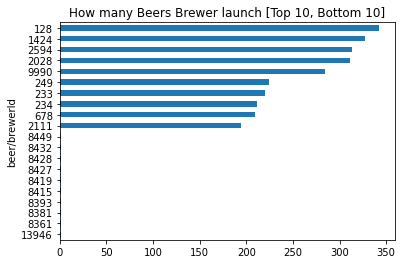

In [18]:
# 생산자의 맥주 생산 개수 분포 확인;  맥주 생산을 많이 하는 생산자와 별로 생산하지 않는 생산자와 같은 정보를 확인한다.
ratebeer.groupby(["beer/brewerId"])["beer/name"].nunique().sort_values(ascending=False).iloc[np.r_[0:10, -10:0]][::-1].plot(kind = 'barh')
plt.title("How many Beers Brewer launch [Top 10, Bottom 10]")
plt.show()

In [ ]:
# 많게는 300개의 맥주를 발매한 회사부터, 1개의 맥주만 발매한 회사도 다수 존재한다.

In [57]:
# 그렇다면 혹시, 맥주를 많이 생산하는 생산자는 전체 리뷰수도 많을까?

top40brewers = ratebeer.groupby(["beer/brewerId"])["beer/name"].nunique().sort_values(ascending=False).head(40).index
brewer_reviews = ratebeer.value_counts("beer/brewerId").reset_index()
brewer_reviews.columns = ["beer/brewerId", "freq"]

brewer_reviews["top40brewer"] = brewer_reviews["beer/brewerId"].isin(top40brewers)
brewer_reviews.sort_values("freq", ascending=False, inplace=True)

brewer_reviews["top40brewer"] = np.where(brewer_reviews["top40brewer"], brewer_reviews["freq"], 0)
brewer_reviews["normal"] = np.where(brewer_reviews["top40brewer"]==False, brewer_reviews["freq"], 0)
brewer_reviews.head()

,beer/brewerId,freq,top40brewer,normal
0,32,46566,46566,0
1,76,38663,0,38663
2,198,37364,0,37364
3,96,35151,0,35151
4,232,32433,32433,0


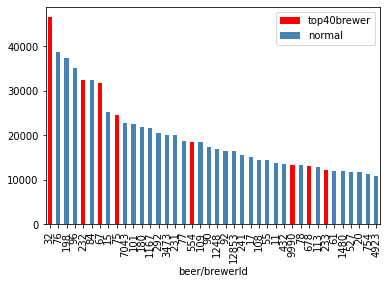

In [58]:
brewer_reviews.drop("freq", axis= 1).set_index("beer/brewerId").head(40).plot(kind = 'bar',  stacked=True, color=['red', 'steelblue', ])
plt.show()

In [59]:
# 맥주 발매량 상위 40개 회사가 모두, 많은 리뷰수를 만들어내지는 못하는 것을 확인할 수 있다.
# 하지만, 맥주 발매량 상위 40개 생산자 내에 많은 수준의 생산자들을 나타내는 것으로 보인다.
# 정리하자면, 어느정도 상관관계가 없다고 할 수 있을지는 모르겠지만, 완전한 경향성을 나타내는 것으로는 보이지 않는다.

### beer/ABV - 맥주 알코올도수 탐색

In [75]:
# 알코올도수는 숫자 타입이여야하는데, 임포트될때, 자동으로 object 타입으로 변경되었던것으로 보아, str 타입의 정보가 포함되어있을수있다.
# 숫자가 아닌 값의 개수는?
abvs = pd.to_numeric(ratebeer["beer/ABV"], errors="coerce") # 숫자가 아닌 타입을 수치형으로 바꾸는데, 실제로 수치형으로 변환 불가한 타입의 정보는 NaN 처리를 해주는 명령어
print(f"[ratebeer] ABV(알코올 도수)에서 결측치('-') 리뷰 개수: {abvs.isna().sum(): 7,}개")
ratebeer["beer/ABV"] = abvs

[ratebeer] ABV(알코올 도수)에서 결측치('-') 개수:  138,637개


In [74]:
# 저네 데이터 개수가 2,924,163개 인 것에 비해서 그렇게 높은 수치는 아닌것 같다. 

In [84]:
# 그렇다면, 몇 개의 맥주가 알코올 도수가 없을까?
n_missing_ABV = ratebeer[ratebeer["beer/ABV"].isna()]["beer/name"].nunique()
print(f"[ratebeer] ABV(알코올 도수)에서 결측치('-') 맥주 개수: {n_missing_ABV: 7,}개")


[ratebeer] ABV(알코올 도수)에서 결측치('-') 맥주 개수:  23,098개


In [ ]:
# 전체 맥주의 개수가 110,299개 이므로, 전체 리뷰에서 결측치의 영향력 보다는 맥주 이름을 기준으로는 훨씬더 결측치의 비율측면에서 더 높은 것으로 보인다. 

In [92]:
# 기본 통계치부터 살펴보자
round(ratebeer["beer/ABV"].describe(), 3)

count    2785526.000
mean           6.641
std            2.314
min            0.010
25%            5.000
50%            6.000
75%            8.000
max           57.700
Name: beer/ABV, dtype: float64

In [93]:
# 맥주가, 알코올이 무려 57.700 까지 높은 것도 존재하고, 논알코올로 보이는것도 존재한다.

### beer/style - 맥주 종류 탐색